In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_x2_var, get_x2_var_short_time
from functions import get_var_hist,simulate_traj, create_R, get_prop_abs, get_steady_mean, get_theo_var_l, get_non_delayed_prop, get_non_delayed_dyn
from setup import setup_matplotlib
from scipy.linalg import expm

setup_matplotlib()


np.random.seed(42)

In [3]:
tau = 1.3
x_0 = 0.3
k = 1
s = 1
D = s**2/2
max_t = 12
ntau = 2
dx = 0.15
eq_perc = 0.75


f = 30
N_p = 2_000
N_loop = 80



def force(x,*args):
     return -k*x

In [4]:
ldt = tau/ntau if tau > 0 else 0.01
N_t = max(int(max_t/ldt), 30)

ts = np.arange(0,N_t)*ldt
sim_ts = np.arange(0,f*(N_t+ntau))*ldt/f-tau


pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,
                    # border=np.array([0]*(f*ntau-1)+[x_0]),
                    border=np.array([x_0]*(f*ntau)),
                    force=force)
sim_var = np.var(pos, axis = 1)

# adapt boundaries to varianz (from sim) -> 3 sigma
sb = 5*np.sqrt(np.max(sim_var))
sb = min(40*dx, np.round(sb/dx)*dx)

x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)
print(N_x, N_x/ (2*np.sqrt(np.max(sim_var))/dx) )
#i_zero = np.array([np.argmin(x_s**2)]*ntau+[np.argmin((x_s+x_0)**2)])
i_zero = np.array([np.argmin((x_s+x_0)**2)]*(ntau+1))


sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)

if tau > 0:
    # v1
    # prop = get_prop_abs(x_s, force,D,ldt,dx)
    # R, _, end_states = create_R(N_x, ntau, prop)

    # v2
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx)
    R, _, end_states = create_R_v1(N_x, ntau, prop)

    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
else:
    R = get_non_delayed_prop(x_s, force,D,ldt,dx)
    hists = get_non_delayed_dyn(R,i_zero,N_t, N_x)

num_var = get_var_hist(hists, x_s)

  0%|          | 0/900 [00:00<?, ?it/s]

81 2.964630736683076


  0%|          | 0/29 [00:00<?, ?it/s]

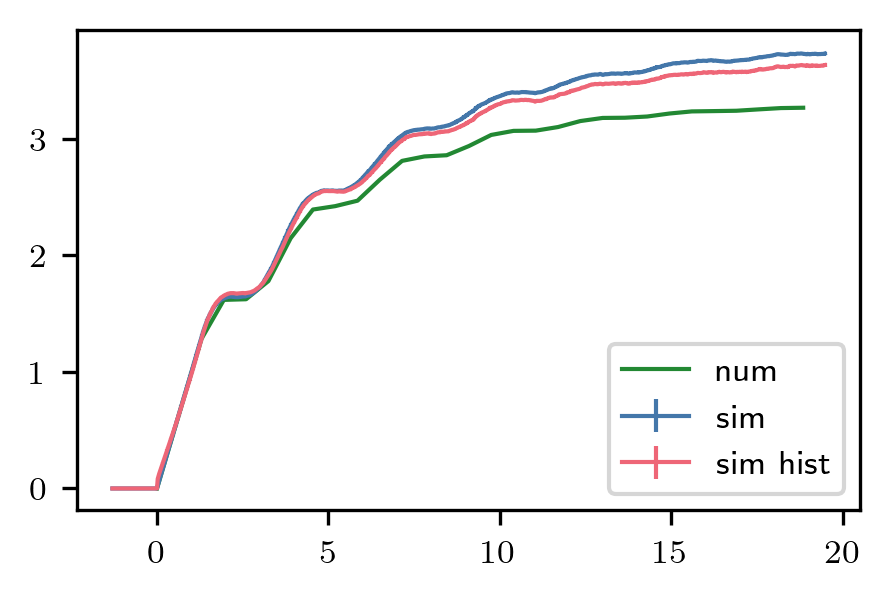

In [5]:
m_sim_var = sim_var.mean(0)
std_sim_var = sim_var.std(0)/np.sqrt(N_loop)

m_sim_hist_var = sim_hist_var.mean(0)
std_sim_hist_var = sim_hist_var.std(0)/np.sqrt(N_loop)

plt.errorbar(sim_ts, m_sim_var, std_sim_var, label = 'sim')
plt.errorbar(sim_ts, m_sim_hist_var, std_sim_hist_var, label = 'sim hist')
plt.plot(ts, num_var,label='num')
plt.legend()

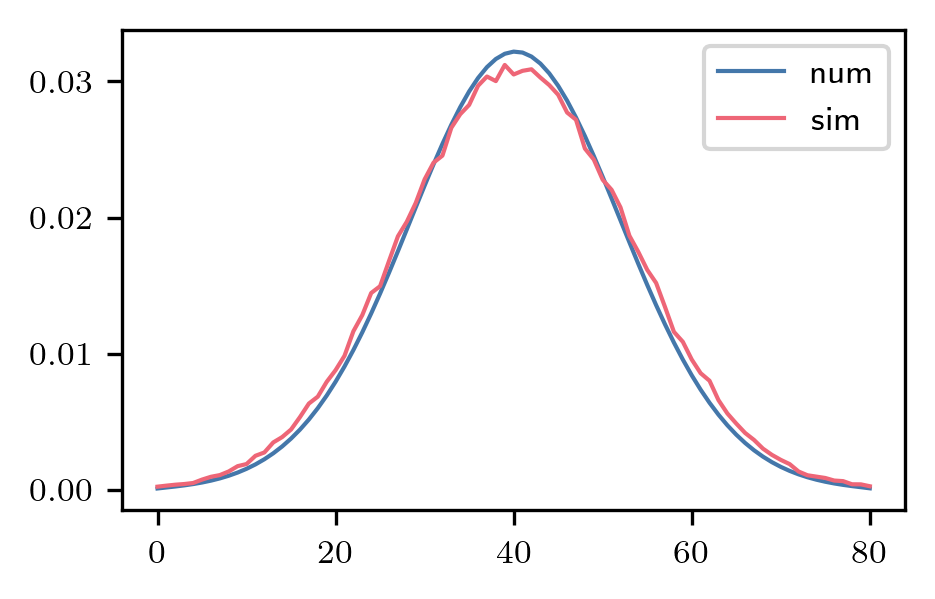

In [6]:
t_hists = sim_hists.sum(0)/sim_hists[:,0].sum()
plt.plot(hists[-1], label = 'num')
plt.plot(t_hists[-1], label = 'sim')
plt.legend()

In [7]:
mean_num = np.sum(x_s*hists, axis = 1)/np.sum(hists, axis = 1)
print(sim_hists.shape)
mean_sim = np.sum(x_s*sim_hists, axis = 2)/np.sum(sim_hists, axis = 2)
mean_mean_sim = mean_sim.mean(0)

(80, 960, 81)


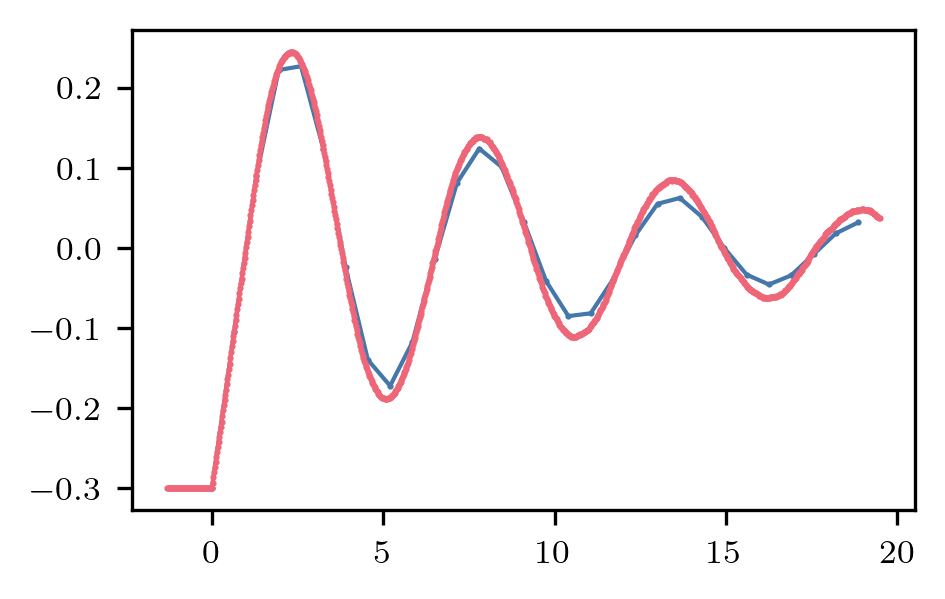

In [8]:
plt.plot(ts,mean_num,'.-', ms = 1)
plt.plot(sim_ts, mean_mean_sim,'.-', ms=1)
# plt.xlim(-1.5,1.5)
# plt.ylim(-0.4,-0.2)
# plt.vlines(np.arange(-1,2)*tau, *plt.ylim())


In [9]:
i_zero

array([38, 38, 38])

In [10]:
x_s

array([-6.00000000e+00, -5.85000000e+00, -5.70000000e+00, -5.55000000e+00,
       -5.40000000e+00, -5.25000000e+00, -5.10000000e+00, -4.95000000e+00,
       -4.80000000e+00, -4.65000000e+00, -4.50000000e+00, -4.35000000e+00,
       -4.20000000e+00, -4.05000000e+00, -3.90000000e+00, -3.75000000e+00,
       -3.60000000e+00, -3.45000000e+00, -3.30000000e+00, -3.15000000e+00,
       -3.00000000e+00, -2.85000000e+00, -2.70000000e+00, -2.55000000e+00,
       -2.40000000e+00, -2.25000000e+00, -2.10000000e+00, -1.95000000e+00,
       -1.80000000e+00, -1.65000000e+00, -1.50000000e+00, -1.35000000e+00,
       -1.20000000e+00, -1.05000000e+00, -9.00000000e-01, -7.50000000e-01,
       -6.00000000e-01, -4.50000000e-01, -3.00000000e-01, -1.50000000e-01,
        1.42108547e-14,  1.50000000e-01,  3.00000000e-01,  4.50000000e-01,
        6.00000000e-01,  7.50000000e-01,  9.00000000e-01,  1.05000000e+00,
        1.20000000e+00,  1.35000000e+00,  1.50000000e+00,  1.65000000e+00,
        1.80000000e+00,  